# Финальное задание по теме обработки изображений
В этом задании вы напишете класс Dataset для задачи сегментации. 

В папке Train_Data находятся изображения. В input — картинки с котиками, в mask — маски изображений. Критерий правильно написанного класса — у вас запустилось обучение.

Датасет небольшой, поэтому не удивляйтесь, что сегментация будет не очень точной, но отрисуйте пару сегментированных котиков. 

Для начала скачайте датасет и положите его на свой Google-диск. 

# Загрузка датасета

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Разархивируем наш датасет

In [2]:
#!g1.1
!unzip Train_Data.zip

The disk was not committed to this checkpoint because the disk usage exceeds the 10 GB limit

Archive:  Train_Data.zip
   creating: Train_Data/
   creating: Train_Data/input/
   creating: Train_Data/mask/
  inflating: Train_Data/input/cat.6.jpg  
  inflating: Train_Data/input/cat.30.jpg  
  inflating: Train_Data/input/cat.24.jpg  
  inflating: Train_Data/input/cat.18.jpg  
  inflating: Train_Data/input/cat.19.jpg  
  inflating: Train_Data/input/cat.25.jpg  
  inflating: Train_Data/input/cat.31.jpg  
  inflating: Train_Data/input/cat.7.jpg  
  inflating: Train_Data/input/cat.5.jpg  
  inflating: Train_Data/input/cat.27.jpg  
  inflating: Train_Data/input/cat.33.jpg  
  inflating: Train_Data/input/cat.32.jpg  
  inflating: Train_Data/input/cat.26.jpg  
  inflating: Train_Data/input/cat.4.jpg  
  inflating: Train_Data/input/cat.0.jpg  
  inflating: Train_Data/input/cat.22.jpg  
  inflating: Train_Data/input/cat.36.jpg  
  inflating: Train_Data/input/cat.37.jpg  
  inflating: Train_Data/input/cat.23.jpg  
  inflating: Train_Data/input/cat.1.jpg  
  inflating: Train_Data/input/cat.3

Импортируем нужные библиотеки

In [48]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#!g1.1


Для решения задачи сегментации будем использовать известную архитектуру Unet.

# UNet архитектура

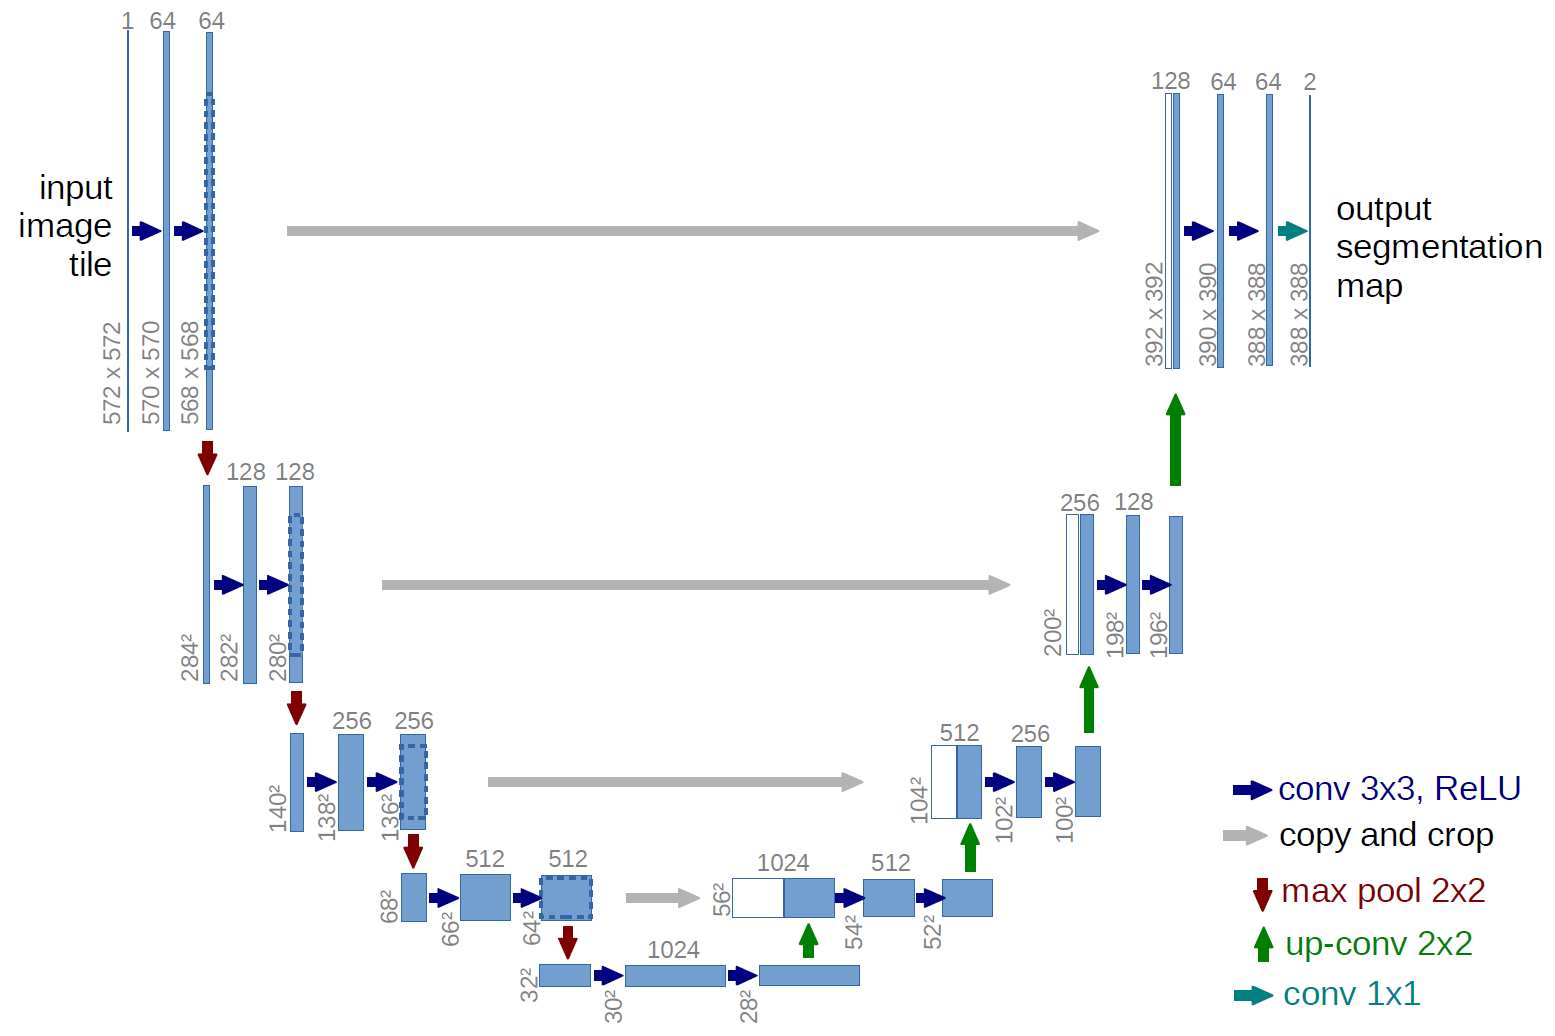

Архитектура UNet используется для сегментации картинок и представляет собой сверточную нейросеть.

Так выглядит архитектура UNet, реализованная в виде кода.

In [49]:
#!g1.1
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Это была общая архитектура. Подробнее об ней вы можете прочитать [здесь](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

Теперь необходимо реализовать отдельные ее блоки.

DoubleConv — блок, состоящий из повторяющихся друг за другом послежовательностей конволюция -> нормализация по батчам -> активация ReLU.

In [50]:
#!g1.1
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


Down — один шажок Downsampling, или понижения размерности. Состоит из пулинга и представленной выше двойной конволюции.

In [51]:
#!g1.1
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

Up — обратная операция, повышение размерности.

In [52]:
#!g1.1
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Класс Dataset

Реализуйте свой класс DataSet

In [56]:
#!g1.1
from PIL import Image
from torchvision import transforms

class my_dataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, path_to_masks):
        self.path_to_images = path_to_images
        self.path_to_masks = path_to_masks
        self.img_dir = os.listdir(self.path_to_images)
        self.mask_dir = os.listdir(self.path_to_masks)
        for img_src in self.img_dir:
            img = Image.open(os.path.join(self.path_to_images+"/"+img_src))
        self.transforms = transforms.Compose([
                                         transforms.Resize((256,256)),
                                        transforms.Grayscale(),
                                         transforms.ToTensor()])


    def __len__(self):
        return len(self.img_dir)


    def __getitem__ (self, idx):
        data = self.transforms(Image.open(os.path.join(self.path_to_images+"/cat."+str(idx)+".jpg"))).cuda()
        target = self.transforms(Image.open(os.path.join(self.path_to_masks+"/mask_cat."+str(idx)+".jpg"))).cuda()
        return (data, target)
              
train_dataset = my_dataset('Train_Data/input', 'Train_Data/mask')
    
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)

# Обучение модели

In [57]:
#!g1.1
def compute_loss(y_pred, y_true):
    return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=0)),dim=0))

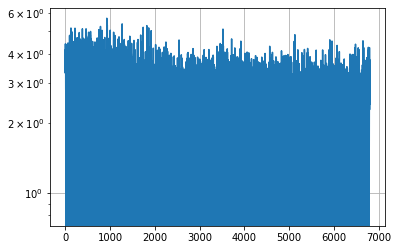

torch.Size([1, 1, 256, 256])


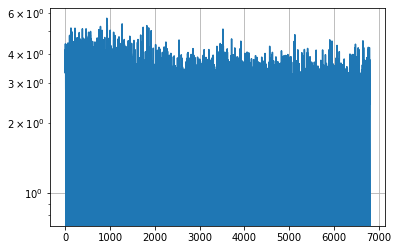

In [58]:
#!g1.1
import time
from IPython.display import clear_output
model = UNet(n_channels=1,n_classes = 1);#UNet(n_class = 2);
model.cuda()
opt = torch.optim.Adam(model.parameters())

num_epochs = 400
train_loss = []

for i in range(num_epochs):
    start_time = time.time()
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        print(X_batch.size())
        loss = compute_loss(model(X_batch),y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        error = loss.item()
        train_loss.append(error)
        
        clear_output(True)
        plt.semilogy(train_loss)
        plt.grid()
        plt.show()

# Оценка результатов

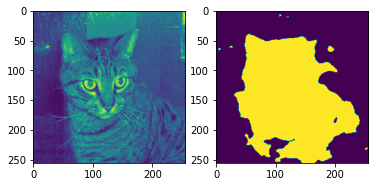

In [62]:
#!g1.1
im = cv2.imread('Train_Data/input/cat.1.jpg')
d = cv2.resize(im.T[1,:,:], (256, 256))
d = d[None]
a = model.forward(torch.FloatTensor(d/255)[None].cuda())
b = a.detach()
c = b.cpu().numpy()
plt.subplot(121)
plt.imshow(d[0,:,:].T)
plt.subplot(122)
plt.imshow(c[0,:,:].squeeze(0).T>0.002)
plt.show()

In [ ]:
from PIL import image
